# Example preprocessing notebook

In this notebook we are going to walk through a single patient example. There are probably some patient-specific stuff in here that might change with other patients. Should be able to demonstrate the usage of different functions from the toolbox.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress
import pandas as pd
import h5py
from mne.preprocessing.bads import _find_outliers

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils

## Load the data and clean up MNE structure

In [4]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results 

save_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/MS007'  # save intermediate results in the 'work' directory
    
# I have saved most of my raw data in the 'projects directory'
behav_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/behav/Day1'
neural_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/neural/Day1'
anat_dir = f'{base_dir}/projects/guLab/Salman/EMU/MS007/anat'
edf_files = glob(f'{neural_dir}/*.edf')




Try loading in the data into memory

In [5]:
MS007_data = mne.io.read_raw_edf(edf_files[0], preload=True)
# If you try to preload, it will kill the kernel (at mem=4000). Probably need to request more memory in Minerva (mem=8000 seems to work)

# # If not preloading: 
# raw_data = MS007_data.get_data()

Extracting EDF parameters from /sc/arion/projects/guLab/Salman/EMU/MS007/neural/Day1/MS007_MemBandit.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1867007  =      0.000 ...  1823.249 secs...


In [6]:
# # this command sets the backend so that the plots are interactive
# get_ipython().run_line_magic('matplotlib', 'qt')

# # plot all channels so that irrelevant/noisy channels can be saved as bad
# MS007_data.plot(n_channels=50)

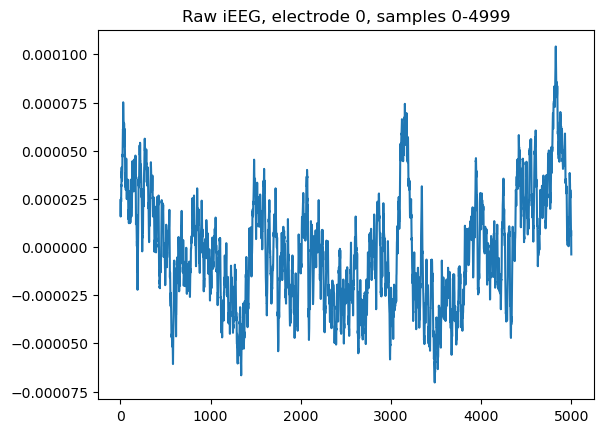

In [7]:
# Sanity check
plt.plot(MS007_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

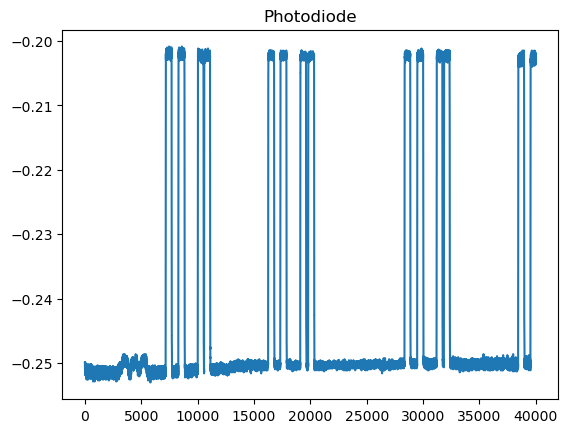

In [8]:
# Sanity check the photodiode
trig_ix = MS007_data.ch_names.index('DC1')
plt.plot(MS007_data._data[trig_ix, 10000:50000])
plt.title("Photodiode")
plt.show()

In [9]:
# Load the electrode localization data and add it in

csv_files = glob(f'{anat_dir}/*labels.csv')
elec_locs = pd.read_csv(csv_files[0])

# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]


The electrode names read out of the edf file do not always match those 
in the pdf (used for localization). This could be error on the side of the tech who input the labels, 
or on the side of MNE reading the labels in. Usually there's a mixup between lowercase 'l' and capital 'I'.

Sometimes, there's electrodes on the pdf that are NOT in the MNE data structure... let's identify those as well. 


In [10]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(MS007_data.ch_names, elec_locs.label)




Could not find a match for rhplt9.


So we retun a new list of channel names for the mne data structure as well as a list of channels in the localization csv which are not found in the mne structure. Make sure that unmatched_seeg does not factor into any referencing schemes later - it's not in the MNE data

In [11]:
# Rename the mne data according to the localization data
new_name_dict = {x:y for (x,y) in zip(MS007_data.ch_names, new_mne_names)}
MS007_data.rename_channels(new_name_dict)

<RawEDF | MS007_MemBandit.edf, 276 x 1867008 (1823.2 s), ~3.84 GB, data loaded>

In [12]:
MS007_data.ch_names

['lmolf1',
 'lmolf2',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf8',
 'lmolf9',
 'rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf5',
 'rmolf6',
 'rmolf7',
 'rmolf8',
 'rmolf9',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'raimm1',
 'raimm2',
 'raimm3',
 'raimm4',
 'raimm5',
 'raimm6',
 'raimm7',
 'raimm8',
 'raimm9',
 'raimm10',
 'raimm11',
 'raimm12',
 'lcmfo1',
 'lcmfo2',
 'lcmfo3',
 'lcmfo4',
 'lcmfo5',
 'lcmfo6',
 'lcmfo7',
 'lcmfo8',
 'lcmfo9',
 'lcmfo10',
 'lcmfo11',
 'lcmfo12',
 'lcmfo13',
 'lcmfo14',
 'c59',
 'c60',
 'c61',
 'c62',
 'c63',
 'c64',
 'rcmfo1',
 'rcmfo2',
 'rcmfo3',
 'rcmfo4',
 'rcmfo5',
 'rcmfo6',
 'rcmfo7',
 'rcmfo8',
 'rcmfo9',
 'rcmfo10',
 'rcmfo11',
 'rcmfo12',
 'rcmfo13',
 'rcmfo14',
 'lacas1',
 'lacas2',
 'lacas3',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas7',
 'lacas8',
 'lacas9',
 'lacas10',
 'lacas11',
 'lacas12',
 'racas

## Now process the channel data


In [13]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in MS007_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data.ch_names if i.startswith('l')]
# This is optional. I might want to look at scalp EEG at some point (lol) so might as well tag them here. 
eeg_names = [
 'fp1',
 'f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 'o2',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz']
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')
print(f'We have a total of {len(eeg_names)} EEG electrodes')
# MS007_data.set_channel_types()

We have a total of 196 sEEG electrodes
We have a total of 19 EEG electrodes


In [14]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
EEG_mapping_dict = {f'{x}':'eeg' for x in eeg_names}
trig_mapping_dict = {'dc1':'stim'}
# Drop random chans? 
drop_chans = list(set(MS007_data.ch_names)^set(eeg_names+left_seeg_names+right_seeg_names+['dc1']))
MS007_data.drop_channels(drop_chans)

<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [15]:
# Set channel types:
MS007_data.set_channel_types(sEEG_mapping_dict)
MS007_data.set_channel_types(EEG_mapping_dict)
MS007_data.set_channel_types(trig_mapping_dict)

/tmp/ipykernel_287625/1830004009.py:4: RuntimeWarning: The unit for channel(s) dc1 has changed from V to NA.
  MS007_data.set_channel_types(trig_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

In [16]:
# Save out the photodiode channel separately
MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif
[done]


/tmp/ipykernel_287625/2725322655.py:2: RuntimeWarning: This filename (/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  MS007_data.save(f'{save_dir}/photodiode.fif', picks='dc1', overwrite=True)


In [17]:
# make montage (convert mm to m)!! 
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

MS007_data.set_montage(montage, match_case=False, on_missing='warn')


/tmp/ipykernel_287625/2987290579.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')
/tmp/ipykernel_287625/2987290579.py:6: RuntimeWarning: DigMontage is only a subset of info. There are 19 channel positions not present in the DigMontage. The required channels are:

['fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  MS007_data.set_montage(montage, match_case=False, on_missing='warn')


<RawEDF | MS007_MemBandit.edf, 216 x 1867008 (1823.2 s), ~3.00 GB, data loaded>

Denote bad channels

In [18]:
# Clean up the MNE data 

bads = lfp_preprocess_utils.detect_bad_elecs(MS007_data, 
                                             sEEG_mapping_dict)

MS007_data.info['bads'] = bads

## Re-referencing

Now, let's use the localization data to determine the gray vs. white matter electrodes. 
Then, let's re-reference each gray matter electrode to the closest and most low-amplitude white matter electrode. 

Make sure 'bad' electrodes are not used in the re-referencing. Same with unmatched seeg electrodes (not present in the mne data structure).

In [19]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(MS007_data, elec_locs, 
                                                       MS007_data.info['bads'], 
                                                       unmatched_seeg=unmatched_seeg)




In [20]:
MS007_data.ch_names

['lmolf1',
 'lmolf2',
 'lmolf3',
 'lmolf4',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf8',
 'lmolf9',
 'rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf5',
 'rmolf6',
 'rmolf7',
 'rmolf8',
 'rmolf9',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'laimm5',
 'laimm6',
 'laimm7',
 'laimm8',
 'laimm9',
 'laimm10',
 'laimm11',
 'laimm12',
 'laimm13',
 'laimm14',
 'raimm1',
 'raimm2',
 'raimm3',
 'raimm4',
 'raimm5',
 'raimm6',
 'raimm7',
 'raimm8',
 'raimm9',
 'raimm10',
 'raimm11',
 'raimm12',
 'lcmfo1',
 'lcmfo2',
 'lcmfo3',
 'lcmfo4',
 'lcmfo5',
 'lcmfo6',
 'lcmfo7',
 'lcmfo8',
 'lcmfo9',
 'lcmfo10',
 'lcmfo11',
 'lcmfo12',
 'lcmfo13',
 'lcmfo14',
 'rcmfo1',
 'rcmfo2',
 'rcmfo3',
 'rcmfo4',
 'rcmfo5',
 'rcmfo6',
 'rcmfo7',
 'rcmfo8',
 'rcmfo9',
 'rcmfo10',
 'rcmfo11',
 'rcmfo12',
 'rcmfo13',
 'rcmfo14',
 'lacas1',
 'lacas2',
 'lacas3',
 'lacas4',
 'lacas5',
 'lacas6',
 'lacas7',
 'lacas8',
 'lacas9',
 'lacas10',
 'lacas11',
 'lacas12',
 'racas1',
 'racas2',
 'racas3',
 'racas4',
 'racas5',


In [21]:
MS007_data_reref = mne.set_bipolar_reference(MS007_data, 
                          anode=anode_list, 
                          cathode=cathode_list,
                          copy=True)

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=108, n_times=1867008
    Range : 0 ... 1867007 =      0.000 ...  1823.249 secs
Ready.
Added the following bipolar channels:
lacas1-lmolf1, lacas10-lacas9, lacas12-lacas9, lacas2-lmolf1, lacas3-lmolf1, lacas4-lacas8, lacas5-lacas8, lacas6-lacas8, lacas7-lacas8, laglt1-laglt4, laglt10-lhplt7, laglt2-laglt4, laglt3-laglt4, laglt7-lhplt6, laglt8-lhplt7, laglt9-lhplt7, laimm1-laglt6, laimm13-laimm11, laimm2-laglt5, laimm3-laimm8, laimm4-lmolf6, laimm5-laimm8, laimm7-laimm8, lcmfo1-lcmfo5, lcmfo12-lcmfo10, lcmfo13-lcmfo10, lcmfo2-lcmfo5, lcmfo3-lcmfo5, lcmfo8-lcmfo9, lhplt1-lhplt6, lhplt10-lhplt6, lhplt2-lhplt6, lhplt3-laglt5, lhplt4-laglt5, lhplt9-lhplt6, lmcms3-lmcms1, lmcms4-lmcms2, lmolf2-lmolf1, lmolf3-lmolf5, lmolf4-lmolf5, lmolf8-lmolf6, lmtpt1-lhplt6, lmtpt2-lcmfo4, lmtpt3-lhplt7, lmtpt4-lhplt7, lmtpt5-lhplt8, lmtpt6-lhplt6, lmtpt7-lhplt6, lmtpt8-lhplt6, lpcip1-lpcip4, lpcip11-lpcip9, lpcip2

In [22]:
MS007_data_reref.drop_channels(drop_wm_channels)

<RawEDF | MS007_MemBandit.edf, 119 x 1867008 (1823.2 s), ~1.66 GB, data loaded>

In [23]:
MS007_data_reref.drop_channels(oob_channels)

<RawEDF | MS007_MemBandit.edf, 108 x 1867008 (1823.2 s), ~1.50 GB, data loaded>

In [24]:
right_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('r')]
left_seeg_names = [i for i in MS007_data_reref.ch_names if i.startswith('l')]
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
MS007_data_reref.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS007_MemBandit.edf, 108 x 1867008 (1823.2 s), ~1.50 GB, data loaded>

In [25]:
# bads = lfp_preprocess_utils.detect_bad_elecs(MS007_data_reref, 
#                                              sEEG_mapping_dict)

In [26]:
# MS007_data_reref.info['bads'] = bads

Using matplotlib as 2D backend.


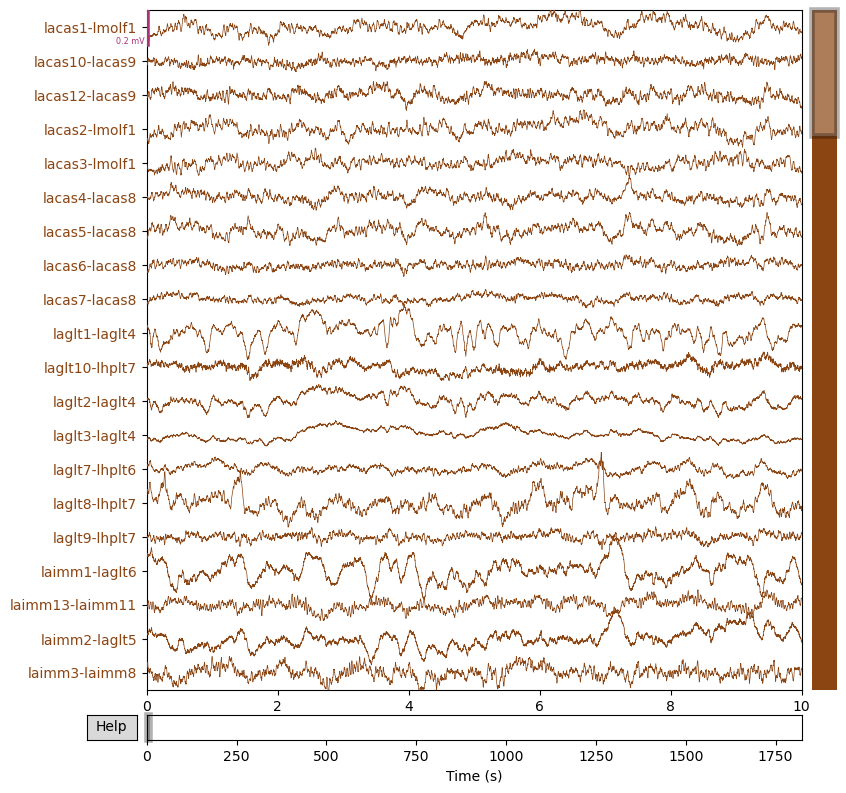

In [27]:
fig = MS007_data_reref.plot()

In [29]:
# Save out the re-referenced data:

MS007_data_reref.save(f'{save_dir}/wm_ref_ieeg.fif', overwrite=True)


Overwriting existing file.
Writing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
Closing /sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS007/wm_ref_ieeg.fif
[done]
